features selected（6 ）：['RTD', 'SI', 'AMN', 'NP', 'RA', 'AT']

Clustering indicators：
 K  Silhouette  Calinski-Harabasz  Davies-Bouldin
 2    0.265006          19.499260        1.382268
 3    0.268551          18.600577        1.460225
 4    0.294830          18.821767        1.235861
 5    0.289500          17.878615        1.130692
 6    0.293395          18.014256        1.086784 



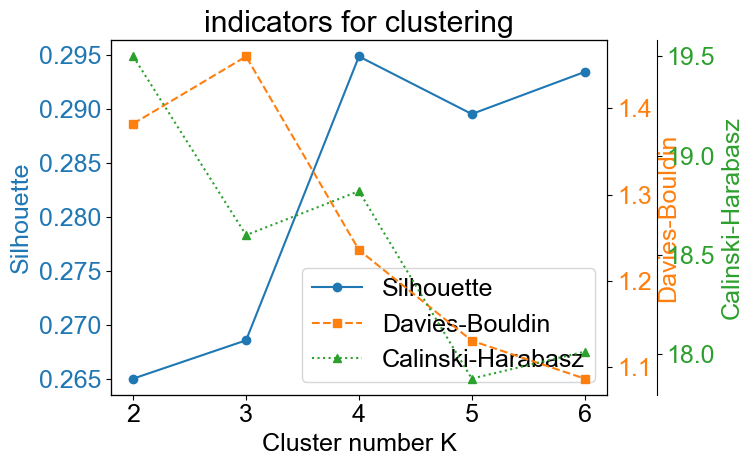

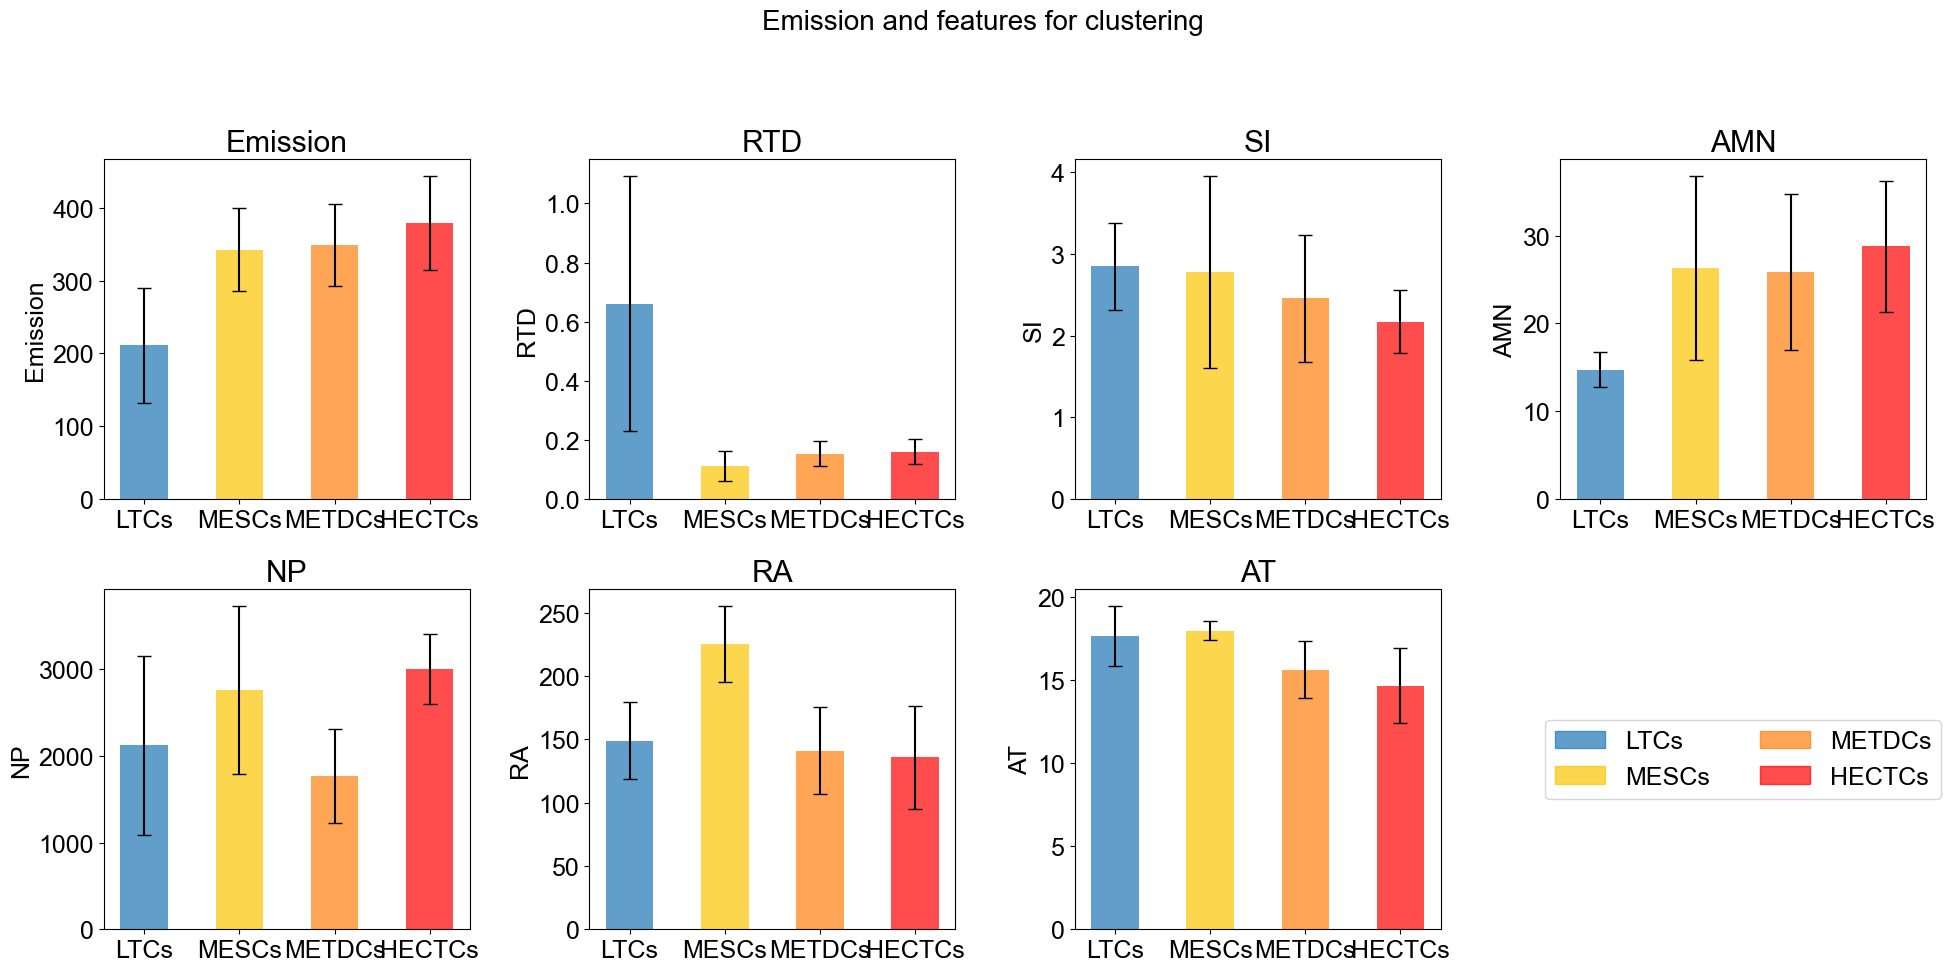

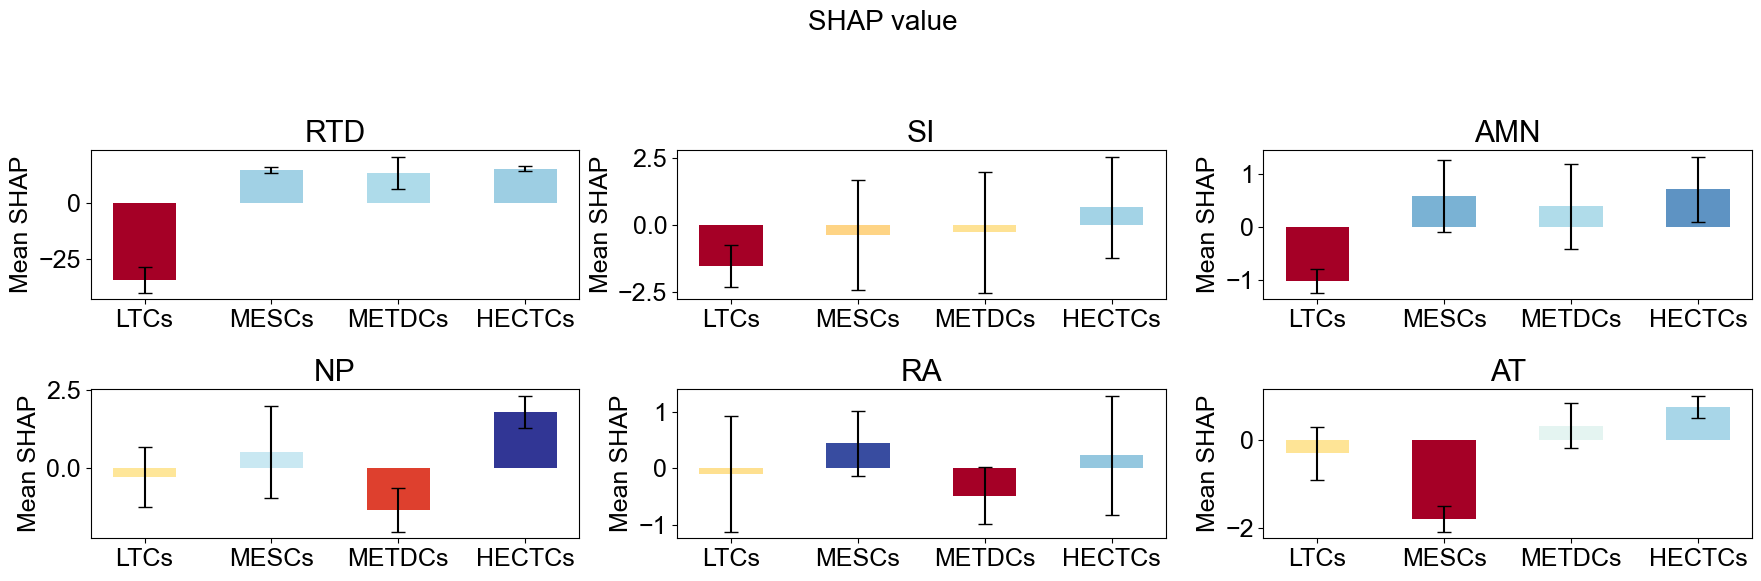

In [2]:
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from matplotlib.colors import TwoSlopeNorm
from matplotlib.patches import Patch

# ───────────────────────────────────────────────────────────
# Global drawing settings: Arial font, black color, size 18
# ───────────────────────────────────────────────────────────
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 18,
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

os.environ["CUDA_VISIBLE_DEVICES"] = ""

# ───────────────────────────────────────────────────────────
# 1. data
# ───────────────────────────────────────────────────────────
file_path = "Analysis_data_0117.xlsx"
df_feat = pd.read_excel(file_path, sheet_name="Figurenew", nrows=51).set_index("cityname")
df_coord = pd.read_excel(
    file_path, sheet_name="Analysis_data",
    usecols=['cityname','GeoCentX','GeoCentY']
).set_index("cityname")
df = df_feat.join(df_coord, how='left')

# Confirm the emission column
em_col = next((c for c in df.columns if c.lower()=="emission"), df.columns[-3])

# Feature X and target y
X = df.drop(columns=[em_col, "GeoCentX", "GeoCentY"])
y = df[em_col]

# ───────────────────────────────────────────────────────────
# 2.Random Forest + Grid Search
# ───────────────────────────────────────────────────────────
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=22)
param_grid = {
    "n_estimators":     [100, 200, 500],
    "max_depth":        [3, 5, 7, None],
    "max_features":     ["sqrt", 0.5, None],
    "min_samples_leaf": [1, 2, 4],
}
grid = GridSearchCV(
    RandomForestRegressor(random_state=0),
    param_grid,
    cv=KFold(5, shuffle=True, random_state=0),
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
grid.fit(X_tr, y_tr)
best_rf = grid.best_estimator_

# ───────────────────────────────────────────────────────────
# 3. Extract the top 16 important features and correlation screening
# ───────────────────────────────────────────────────────────
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
top_feats = importances.sort_values(ascending=False).head(16).index.tolist()

corr = X[top_feats].corr().abs()
keep = []
for feat in top_feats:
    if all(corr.loc[feat, k] <= 0.6 for k in keep):
        keep.append(feat)

print(f"features selected（{len(keep)} ）：{keep}\n")

# ───────────────────────────────────────────────────────────
# 4. calculate SHAP
# ───────────────────────────────────────────────────────────
explainer = shap.TreeExplainer(best_rf)
shap_vals = explainer.shap_values(X)
shap_df = pd.DataFrame(shap_vals, index=X.index, columns=X.columns)
shap_sel = shap_df[keep]

scaler = StandardScaler()
shap_scaled = scaler.fit_transform(shap_sel)

# ───────────────────────────────────────────────────────────
# 5. k=2:6
# ───────────────────────────────────────────────────────────
metrics = []
for k in range(2, 7):
    lbl = KMeans(n_clusters=k, random_state=0, n_init=10).fit_predict(shap_scaled)
    metrics.append({
        'K': k,
        'Silhouette':        silhouette_score(shap_scaled, lbl),
        'Calinski-Harabasz': calinski_harabasz_score(shap_scaled, lbl),
        'Davies-Bouldin':    davies_bouldin_score(shap_scaled, lbl)
    })
metrics_df = pd.DataFrame(metrics)
print("Clustering indicators：")
print(metrics_df.to_string(index=False), "\n")

# ───────────────────────────────────────────────────────────
# 6. draw plot
# ───────────────────────────────────────────────────────────
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(metrics_df["K"], metrics_df["Silhouette"], marker="o", label="Silhouette")
ax1.set_xlabel("Cluster number K")
ax1.set_ylabel("Silhouette", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(metrics_df["K"], metrics_df["Davies-Bouldin"],
         marker="s", linestyle="--", color="tab:orange", label="Davies-Bouldin")
ax2.set_ylabel("Davies-Bouldin", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

ax3 = ax1.twinx()
ax3.spines.right.set_position(("axes", 1.1))
ax3.plot(metrics_df["K"], metrics_df["Calinski-Harabasz"],
         marker="^", linestyle=":", color="tab:green", label="Calinski-Harabasz")
ax3.set_ylabel("Calinski-Harabasz", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

lines, labels = [], []
for ax in (ax1, ax2, ax3):
    lns, lbs = ax.get_lines(), [l.get_label() for l in ax.get_lines()]
    lines += lns; labels += lbs
ax1.legend(lines, labels, loc="best")

plt.title("indicators for clustering")
plt.tight_layout()
fig1.savefig("cluster_metrics.svg", format="svg", dpi=300)
plt.show()

# ───────────────────────────────────────────────────────────
# 7. with K=4
# ───────────────────────────────────────────────────────────
K = 4
kmeans = KMeans(n_clusters=K, random_state=0, n_init=50)
labels = kmeans.fit_predict(shap_scaled)
df["Cluster"] = labels

# ───────────────────────────────────────────────────────────
# 8. cluster features calculation
# ───────────────────────────────────────────────────────────
cluster_em   = df.groupby("Cluster")[em_col].agg(['mean','std','min','max','count'])
cluster_feat = X[keep].groupby(df["Cluster"]).agg(['mean','std'])
cluster_shap = shap_sel.groupby(df["Cluster"]).agg(['mean','std'])

# ───────────────────────────────────────────────────────────
# 9. Color
# ───────────────────────────────────────────────────────────
cluster_order  = [0, 3, 1, 2]
color_map      = {0:"#1E77B4", 3:"#FBC500", 1:"#FF7F0F", 2:"#FF0000"}
cluster_labels = {0:"LTCs", 3:"MESCs", 1:"METDCs", 2:"HECTCs"}
bar_width      = 0.5
alpha_val      = 0.7

# ───────────────────────────────────────────────────────────
# 10. Emission & features：2×4
# ───────────────────────────────────────────────────────────
fig2, axes = plt.subplots(2, 4, figsize=(20, 10), squeeze=False)
axs = axes.flatten()
fig2.suptitle("Emission and features for clustering", fontsize=20)

# (1) Emission
m_em = cluster_em['mean'].loc[cluster_order]
s_em = cluster_em['std'].loc[cluster_order]
axs[0].bar(np.arange(4), m_em, width=bar_width, yerr=s_em, capsize=5,
           color=[color_map[c] for c in cluster_order], alpha=alpha_val)
axs[0].set_xticks(np.arange(4))
axs[0].set_xticklabels([cluster_labels[c] for c in cluster_order])
axs[0].set_title("Emission")
axs[0].set_ylabel("Emission")

# (2) 6 features
for i, feat in enumerate(keep):
    m = cluster_feat[feat]['mean'].loc[cluster_order]
    s = cluster_feat[feat]['std'].loc[cluster_order]
    ax = axs[i+1]
    ax.bar(np.arange(4), m, width=bar_width, yerr=s, capsize=5,
           color=[color_map[c] for c in cluster_order], alpha=alpha_val)
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels([cluster_labels[c] for c in cluster_order])
    ax.set_title(feat)
    ax.set_ylabel(feat)

# (3) 簇图例
axs[7].axis("off")
patches = [Patch(color=color_map[c], label=cluster_labels[c], alpha=alpha_val)
           for c in cluster_order]
axs[7].legend(handles=patches, loc="center", ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.94])
fig2.savefig("emission_features.svg", format="svg", dpi=300)
plt.show()

# ───────────────────────────────────────────────────────────
# 11. SHAP：2×3 
# ───────────────────────────────────────────────────────────
fig3, axes = plt.subplots(2, 3, figsize=(18, 6), squeeze=False)
axs = axes.flatten()
fig3.suptitle("SHAP value", fontsize=20)

for i, feat in enumerate(keep):
    m = cluster_shap[feat]['mean'].loc[cluster_order]
    s = cluster_shap[feat]['std'].loc[cluster_order]
    vmax = np.max(np.abs(m))
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    cmap = plt.get_cmap("RdYlBu")
    colors = [cmap(norm(v)) for v in m]
    ax = axs[i]
    ax.bar(np.arange(4), m, width=bar_width, yerr=s, capsize=5,
           color=colors)  
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels([cluster_labels[c] for c in cluster_order])
    ax.set_title(feat)
    ax.set_ylabel("Mean SHAP")

plt.tight_layout(rect=[0, 0, 1, 0.93])
fig3.savefig("shap_features.svg", format="svg", dpi=300)
plt.show()